# Flickbike case exercise 2

## Research (Exercise 1)
1. **Hoe voorspel je het aantal verhuurde fietsen op de dagen tussen 10 december 2019 en 31 januari 2020?**
    1. Onderzoek doen naar factoren die invloed hebben op het aantal verhuurde fietsen.
    2. Kijk wat de bestaande data te bieden heeft.
    3. Kijk wat voor aanvullende data je nodig moet hebben om meer factoren in kaart te brengen.
    4. Laad de data in in een Jupyter notebook.
    5. Identificeer de kolommen.
    6. Identificeer de types + range van elke kolom.
    7. Identificeer hoeveel unieke waarde elke kolom heeft.
    8. Kijk of er sprake is van trends in het aantal verhuurde fiets. ( kan soms met blote oog, of statistisch)
    9. Als er sprake is van een sterkte trend, gebruik een model wat hier goed bij past. (bv. SARIMA)
    10. Als er geen sprake is van een tijdsgebonden trend, zoek correlaties met andere kolommen.
    11. Als er sprake is van correlaties in bepaalde kolommen, gebruik een regressie model. 
    12. Als er geen relatie is, probeer nieuwe factoren. (Stap 3)


2. **Welke invloeden verwacht je van dat ze relevant zijn?**
     - Weer: Er gaan minder mensen fietsen als het regent.
     - De dagen van de week: Doordeweeks werken er meer mensen dan in het weekend en vertonen ze ander gedrag.
     - Feestdagen: Feestdagen zijn vaak vrije dagen en dus werken er geen mensen en vertonen ze ander gedrag.
     - Economische crisis: bij een economische crisis is de werkloosheid lager, en dus mogelijk minder gehuurde fietsen.

3. **Op welke manier kun je je model gevoelig maken voor bepaalde factoren?**

Door middel van libraries als keras is het mogelijk om de gewichten automatisch te laten bepalen, hierdoor hoef je dat dus zelf niet te doen.


4. **Hoe kan, op basis van data, worden voorspeld waar er tekorten van fietsen dreigen te ontstaan en hoe de fietsen het beste zo kunnen worden verplaatst dat ze zowel over het hele terrein van Schiphol-Oost beschikbaar zijn en tegelijkertijd vooral beschikbaar zijn op plaatsen waar het regelmatig druk is?**

Hier zou het mogelijk zijn om een simulatie uit te voeren. Een andere optie is om een statistisch model op lokaal niveau uit te voeren. Zo krijg je een beeld per locatie. Deze locatiegebieden zouden mogelijk met een unsupervised learning techniek bepaald kunnen worden.
    
5. **Hoe kun je berekenen met hoeveel fietsen FlickBike minimaal zou kunnen werken, zodanig dat te verwachten pieken op te vangen zijn?**

Het antwoord op deze vraag is afhankelijk van de uitwerking van de vorige vraag. Als de fietsen goed verdeeld worden, en dus naar plekken waar pieken plaatsvinden meer fietsen verplaatst worden, dan zijn er minder fietsen nodig dan dat je hier domweg overal de zelfde fietsen neerzet. Er is dus niet direct een concreet antwoord op deze vraag.


## Visualisaties

**Vraag 1:** Een plot met op de X-as de tijd in dagen/weken, afhankelijk van de historische data, op de Y-as het aantal verhuurde fietsen. Een deel van de lijn zal een andere kleur hebben en dit zal de voorspelling zijn.

**Vraag 2:** Een correlatiematrix.

**Vraag 3:** N.v.t.

**Vraag 4:** Een simpele visualisatie van de simulatie of een heatmap.

**Vraag 5:** Idem. Deze gaat hand in hand met vraag 4.

### Import data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Import flickbike data
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

### Data exploration

In [3]:
# Check if there are any zeroes
df = pd.concat([train_df, test_df])
df.isnull().any()

Unnamed: 0    False
tripid        False
userid        False
bikeid        False
account       False
bikenumber    False
start_time    False
end_time      False
start_lat     False
start_lng     False
end_lat       False
end_lng       False
date          False
dtype: bool

In [4]:
# Convert date to datetime
df.date = pd.to_datetime(df.date)
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)

In [5]:
original_df = df.copy()

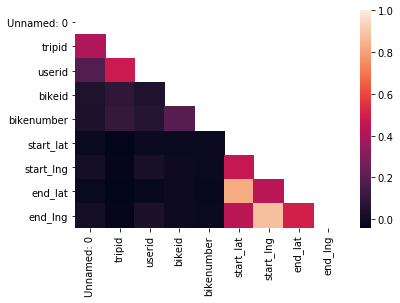

In [6]:
# Plot correlation
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask)
plt.show()

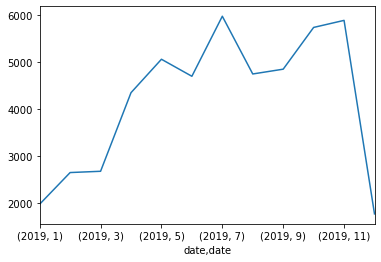

C:\Users\berry\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\frame.py:7134: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return concat(


In [7]:
# Show overview of rented bikes
from datetime import datetime
df.date.groupby([df.date.dt.year, df.date.dt.month]).agg('count').plot()
plt.show()
count_by_day = pd.DataFrame(df.date.groupby([df.date.dt.year, df.date.dt.month, df.date.dt.day]).agg('count'))
count_by_day.columns = ['Count']
count_by_day.index.rename('year', level=0, inplace=True)
count_by_day.index.rename('month', level=1, inplace=True)
count_by_day.index.rename('day', level=2, inplace=True)
count_by_day.reset_index(inplace=True)
count_by_day['date'] = pd.to_datetime(count_by_day[['year', 'month', 'day']])

# Add dates to predict to dataframe
extra_data = pd.DataFrame()
extra_data['date'] = pd.date_range(datetime(2019, 12, 10), datetime(2020, 2, 1))
extra_data['year'] = extra_data['date'].dt.year
extra_data['month'] = extra_data['date'].dt.month
extra_data['day'] = extra_data['date'].dt.day
extra_data['Count'] = 0


count_by_day = count_by_day.append(extra_data)

### Data enrichment
Since Flickbike is operating as a B2B company, the weekday and national holidays will probably be relevant. We will be adding those. This data is retrieved from: https://kalender-nederland.nl/

Also, since Flickbike is renting out bikes, weather data will be relevant, the don't like to cycle when it's raining. We will add this data. This data is retrieved from: http://projects.knmi.nl/klimatologie/daggegevens/selectie.cgi

In [8]:
# Import holidays
national_holidays = pd.read_csv("./data/Nationale Feestdagen.csv")
other_holidays = pd.read_csv("./data/Overige Feestdagen.csv")
holidays = pd.concat([national_holidays, other_holidays], ignore_index=True)
holidays = national_holidays

In [9]:
# Show sample holidays
holidays.head()

,Feestdag,Datum
0,Nieuwjaarsdag 2019,01 Jan 2019
1,Bevrijdingsdag 2019,05 May 2019
2,Hemelvaart 2019,30 May 2019
3,Goede vrijdag 2019,19 Apr 2019
4,1e Paasdag 2019,21 Apr 2019


In [10]:
# Set `Datum` to datetime
holidays.Datum = pd.to_datetime(holidays.Datum)

In [11]:
# Save as string date-month
holidays.Datum = holidays.Datum.dt.strftime('%d-%m')
holidays.Datum

0     01-01
1     05-05
2     30-05
3     19-04
4     21-04
5     22-04
6     27-04
7     09-06
8     10-06
9     25-12
10    26-12
Name: Datum, dtype: object

In [12]:
# Add column "special_day" to bike data, to enrich the data and define if that day is a holiday or not.
df['month_year'] = df.date.dt.strftime('%d-%m')
df['special_day'] = df['month_year'].isin(holidays.Datum) * 1
del df['month_year']

# Add to daily count data aswell
count_by_day['month_year'] = count_by_day.date.dt.strftime('%d-%m')
count_by_day['special_day'] = count_by_day['month_year'].isin(holidays.Datum) * 1
del count_by_day['month_year']
count_by_day

,Count,date,day,month,year,special_day
0,8,2019-01-01,1,1,2019,1
1,61,2019-01-02,2,1,2019,0
2,90,2019-01-03,3,1,2019,0
3,64,2019-01-04,4,1,2019,0
4,17,2019-01-05,5,1,2019,0
...,...,...,...,...,...,...
49,0,2020-01-28,28,1,2020,0
50,0,2020-01-29,29,1,2020,0
51,0,2020-01-30,30,1,2020,0
52,0,2020-01-31,31,1,2020,0


In [13]:
# See how many rentals where on a special day
print("Average normal day:", int(count_by_day['Count'][count_by_day['special_day'] == 0].mean()))
print("Average holiday:", int(count_by_day['Count'][count_by_day['special_day'] == 1].mean()))

Average normal day: 130
Average holiday: 24


In [14]:
# See how many rentals are divided over different days, where 0 is monday.
df.date.dt.weekday.value_counts()

1    10813
3    10557
2     9779
0     9406
4     7755
5     1096
6      971
Name: date, dtype: int64

In [15]:
# Add weekday to day count dataframe
count_by_day['weekday'] = count_by_day.date.dt.weekday

In [16]:
# Add boolean is_workday (ma-fr) to day count dataframe
count_by_day['is_workday'] = count_by_day.date.dt.weekday.between(0,4) * 1

### Weather data

In [17]:
# Import KNMI Weather data
KNMI_2019 = pd.read_csv("./data/KNMI_weerdata.csv")
KNMI_2020 = pd.read_csv("./data/KNMI_weerdata2020.csv")[['YYYYMMDD','FHX','FHN','FXX','TN','TX','SQ','SP','DR','RH','RHX','VVN' ,'VVX', 'STN']]
KNMI = KNMI_2019.append(KNMI_2020)
locatie_STN = pd.read_csv("./data/locatie_meetstations.csv")

In [18]:
KNMI

,DR,FHN,FHX,FXX,RH,RHX,SP,SQ,STN,TN,TX,VVN,VVX,YYYYMMDD
0,NaN,70.0,140.0,210.0,NaN,NaN,NaN,NaN,209,NaN,NaN,NaN,NaN,20190101
1,NaN,40.0,130.0,190.0,NaN,NaN,NaN,NaN,209,NaN,NaN,NaN,NaN,20190102
2,NaN,50.0,80.0,130.0,NaN,NaN,NaN,NaN,209,NaN,NaN,NaN,NaN,20190103
3,NaN,50.0,100.0,130.0,NaN,NaN,NaN,NaN,209,NaN,NaN,NaN,NaN,20190104
4,NaN,80.0,110.0,150.0,NaN,NaN,NaN,NaN,209,NaN,NaN,NaN,NaN,20190105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6199,0.0,0.0,20.0,50.0,0.0,0.0,75.0,114.0,391,20.0,224.0,NaN,NaN,20200507
6200,0.0,0.0,30.0,50.0,0.0,0.0,59.0,89.0,391,46.0,236.0,NaN,NaN,20200508
6201,0.0,0.0,30.0,80.0,0.0,0.0,81.0,124.0,391,83.0,258.0,NaN,NaN,20200509
6202,10.0,0.0,80.0,160.0,6.0,4.0,4.0,6.0,391,64.0,215.0,NaN,NaN,20200510


In [19]:
# Some weatherstations do not have all columns, those should not be used.
incomplete = KNMI[KNMI.isnull().any(axis=1)].STN.unique()

# Remove from weather data
KNMI = KNMI[~KNMI.STN.isin(incomplete)]
KNMI = KNMI[['YYYYMMDD','FHX','FHN','FXX','TN','TX','SQ','SP','DR','RH','RHX','VVN' ,'VVX', 'STN']]

# Remove from locations
locatie_STN = locatie_STN[~locatie_STN.STN.isin(incomplete)]

In [20]:
# Some locations are not in the dataset, those should be removed from locations aswell
locatie_STN = locatie_STN[locatie_STN.STN.isin(KNMI.STN.unique())]

In [21]:
# Set YYYYMMDD to datetime object
KNMI['date'] = pd.to_datetime(KNMI['YYYYMMDD'], format='%Y%m%d' ).dt.date

In [22]:
# Add datetime object to bike count data
count_by_day['day_of_year'] = count_by_day['date'].dt.date
count_by_day

,Count,date,day,month,year,special_day,weekday,is_workday,day_of_year
0,8,2019-01-01,1,1,2019,1,1,1,2019-01-01
1,61,2019-01-02,2,1,2019,0,2,1,2019-01-02
2,90,2019-01-03,3,1,2019,0,3,1,2019-01-03
3,64,2019-01-04,4,1,2019,0,4,1,2019-01-04
4,17,2019-01-05,5,1,2019,0,5,0,2019-01-05
...,...,...,...,...,...,...,...,...,...
49,0,2020-01-28,28,1,2020,0,1,1,2020-01-28
50,0,2020-01-29,29,1,2020,0,2,1,2020-01-29
51,0,2020-01-30,30,1,2020,0,3,1,2020-01-30
52,0,2020-01-31,31,1,2020,0,4,1,2020-01-31


In [23]:
# To make this generic, it should be possible to
# get waetherdata for other places aswell. 
# That's why we get for each record the closest weather station, but for now, since all data is close to Schiphol, we'll stick to weather station with ID 240, since it's the weather station at Schiphol.
from scipy.spatial.distance import cdist

def closest_point(point, points):
        """ Find closest point from a list of points. """
        return points[cdist([point], points).argmin()]

def match_value(df, col1, x, col2):
    """ Match value x from col1 row to value in col2. """
    return df[df[col1] == x][col2].values[0]

ONLY_AMSTERDAM = True

if not ONLY_AMSTERDAM:
    # Get lat, lon as point
    locatie_STN['point'] = [(x, y) for x,y in zip(locatie_STN['LAT'], locatie_STN['LON'])]
    count_by_day['point'] = [(x, y) for x,y in zip(count_by_day['start_lat'], count_by_day['start_lng'])]

    # Set closest weather station
    count_by_day['closest_coord'] = [closest_point(x, list(locatie_STN['point'])) for x in count_by_day['point']]
    count_by_day['closest_weather_station'] = [match_value(locatie_STN, 'point', x, 'STN') for x in count_by_day['closest_coord']]
else:
    count_by_day['closest_weather_station'] = 240

In [24]:
# Merge KNMI date to day count dataframe
count_by_day = pd.merge(count_by_day, KNMI,  how='inner', left_on=['day_of_year','closest_weather_station'], right_on = ['date','STN'])
count_by_day

,Count,date_x,day,month,year,special_day,weekday,is_workday,day_of_year,closest_weather_station,...,TX,SQ,SP,DR,RH,RHX,VVN,VVX,STN,date_y
0,8,2019-01-01,1,1,2019,1,1,1,2019-01-01,240,...,91.0,13.0,17.0,23.0,5.0,2.0,30.0,75.0,240,2019-01-01
1,61,2019-01-02,2,1,2019,0,2,1,2019-01-02,240,...,71.0,4.0,5.0,0.0,-1.0,-1.0,62.0,75.0,240,2019-01-02
2,90,2019-01-03,3,1,2019,0,3,1,2019-01-03,240,...,68.0,46.0,59.0,0.0,-1.0,-1.0,65.0,75.0,240,2019-01-03
3,64,2019-01-04,4,1,2019,0,4,1,2019-01-04,240,...,68.0,0.0,0.0,0.0,-1.0,-1.0,37.0,75.0,240,2019-01-04
4,17,2019-01-05,5,1,2019,0,5,0,2019-01-05,240,...,81.0,0.0,0.0,6.0,1.0,1.0,50.0,75.0,240,2019-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0,2020-01-28,28,1,2020,0,1,1,2020-01-28,240,...,70.0,21.0,24.0,46.0,74.0,41.0,50.0,80.0,240,2020-01-28
393,0,2020-01-29,29,1,2020,0,2,1,2020-01-29,240,...,80.0,8.0,9.0,13.0,8.0,6.0,63.0,75.0,240,2020-01-29
394,0,2020-01-30,30,1,2020,0,3,1,2020-01-30,240,...,115.0,19.0,21.0,31.0,7.0,2.0,18.0,71.0,240,2020-01-30
395,0,2020-01-31,31,1,2020,0,4,1,2020-01-31,240,...,125.0,3.0,3.0,4.0,2.0,2.0,28.0,70.0,240,2020-01-31


In [25]:
# remove temporary columns
if 'date_y' in count_by_day.columns:
    count_by_day.drop(columns=['date_y', 'STN', 'YYYYMMDD', 'closest_weather_station'], inplace=True)

count_by_day.dtypes

Count                   int64
date_x         datetime64[ns]
day                     int64
month                   int64
year                    int64
special_day             int32
weekday                 int64
is_workday              int32
day_of_year            object
FHX                   float64
FHN                   float64
FXX                   float64
TN                    float64
TX                    float64
SQ                    float64
SP                    float64
DR                    float64
RH                    float64
RHX                   float64
VVN                   float64
VVX                   float64
dtype: object

In [26]:
# Set index as column to create a column representing the number of days in business
count_by_day['dayNumber'] = count_by_day.index

In [27]:
raw_count_by_day = count_by_day.copy()

# Show sample of data
count_by_day.sample(10)

,Count,date_x,day,month,year,special_day,weekday,is_workday,day_of_year,FHX,...,TN,TX,SQ,SP,DR,RH,RHX,VVN,VVX,dayNumber
367,0,2020-01-03,3,1,2020,0,4,1,2020-01-03,100.0,...,42.0,105.0,0.0,0.0,56.0,26.0,6.0,27.0,70.0,367
30,107,2019-01-31,31,1,2019,0,3,1,2019-01-31,60.0,...,-18.0,10.0,8.0,9.0,13.0,8.0,7.0,6.0,65.0,30
174,273,2019-06-25,25,6,2019,0,1,1,2019-06-25,50.0,...,180.0,324.0,97.0,58.0,0.0,0.0,0.0,34.0,80.0,174
371,0,2020-01-07,7,1,2020,0,1,1,2020-01-07,100.0,...,29.0,84.0,31.0,39.0,3.0,1.0,1.0,36.0,65.0,371
201,179,2019-07-22,22,7,2019,0,0,1,2019-07-22,80.0,...,158.0,260.0,116.0,72.0,0.0,0.0,0.0,70.0,82.0,201
230,232,2019-08-20,20,8,2019,0,1,1,2019-08-20,70.0,...,116.0,208.0,114.0,79.0,0.0,-1.0,-1.0,61.0,81.0,230
163,172,2019-06-14,14,6,2019,0,4,1,2019-06-14,70.0,...,105.0,224.0,87.0,52.0,7.0,10.0,9.0,63.0,82.0,163
220,34,2019-08-10,10,8,2019,0,5,0,2019-08-10,160.0,...,172.0,230.0,81.0,54.0,5.0,8.0,3.0,61.0,75.0,220
159,11,2019-06-10,10,6,2019,1,0,1,2019-06-10,90.0,...,142.0,215.0,56.0,34.0,8.0,75.0,75.0,59.0,82.0,159
59,99,2019-03-01,1,3,2019,0,4,1,2019-03-01,60.0,...,32.0,82.0,9.0,8.0,0.0,-1.0,-1.0,5.0,75.0,59


### Modelling

In [28]:
# Prepare data for model
model_df = count_by_day[['dayNumber', 'Count', 'date_x', 'special_day', 'weekday',
            'is_workday', 'FHX', 'FHN', 'FXX', 'TN', 'TX', 'SQ',
            'SP', 'DR', 'RH', 'RHX', 'VVN', 'VVX']
            ]

daysMap = {
    0: 'Monday', 
    1: 'Tuesday', 
    2: 'Wednesday', 
    3: 'Thursday', 
    4: 'Friday', 
    5: 'Saturday', 
    6: 'Sunday'
}
# weekday is categorical. This should be mapped.
model_df['weekday'] = model_df['weekday'].map(daysMap)
model_df = pd.get_dummies(model_df, prefix='', prefix_sep='')
model_df.tail()

<ipython-input-28-677cfd54bb49>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df['weekday'] = model_df['weekday'].map(daysMap)


,dayNumber,Count,date_x,special_day,is_workday,FHX,FHN,FXX,TN,TX,...,RHX,VVN,VVX,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
392,392,0,2020-01-28,0,1,130.0,50.0,190.0,39.0,70.0,...,41.0,50.0,80.0,0,0,0,0,0,1,0
393,393,0,2020-01-29,0,1,110.0,60.0,160.0,49.0,80.0,...,6.0,63.0,75.0,0,0,0,0,0,0,1
394,394,0,2020-01-30,0,1,110.0,60.0,180.0,70.0,115.0,...,2.0,18.0,71.0,0,0,0,0,1,0,0
395,395,0,2020-01-31,0,1,120.0,60.0,180.0,83.0,125.0,...,2.0,28.0,70.0,1,0,0,0,0,0,0
396,396,0,2020-02-01,0,0,120.0,80.0,180.0,88.0,120.0,...,7.0,33.0,70.0,0,0,1,0,0,0,0


In [29]:
# Split data
split_date = pd.datetime(2019,11,1)
train_data = model_df.loc[model_df.date_x < split_date]
test_data = model_df.loc[model_df.date_x >= split_date]

In [30]:
train_stats = train_data.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
dayNumber,303.0,151.000000,87.612784,0.0,75.5,151.0,226.5,302.0
Count,303.0,140.990099,98.162876,3.0,31.5,145.0,225.5,400.0
special_day,303.0,0.026403,0.160595,0.0,0.0,0.0,0.0,1.0
is_workday,303.0,0.719472,0.450000,0.0,0.0,1.0,1.0,1.0
FHX,303.0,73.795380,27.532961,20.0,60.0,70.0,90.0,170.0
FHN,303.0,23.960396,16.801088,0.0,10.0,20.0,30.0,90.0
FXX,303.0,118.910891,42.509858,40.0,90.0,110.0,140.0,250.0
TN,303.0,80.128713,53.488687,-71.0,40.5,84.0,119.5,199.0
TX,303.0,164.762376,67.042412,-2.0,113.0,173.0,212.0,364.0
SQ,303.0,60.019802,43.900093,0.0,21.0,56.0,97.0,155.0


In [31]:
# show ranges
print('Latest train data:', train_data.date_x.max())
print('Oldest test data:', test_data.date_x.min())

Latest train data: 2019-10-31 00:00:00
Oldest test data: 2019-11-01 00:00:00


In [32]:
train_labels = train_data.pop('Count')
train_dates = train_data.pop('date_x')

In [33]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_data.loc[:, train_data.columns != 'date_x'])
normed_test_data = norm(test_data.loc[:, test_data.columns != 'date_x'])

del normed_train_data['Count']
del normed_test_data['Count']

In [34]:
average_not_work_day = raw_count_by_day.Count[raw_count_by_day.is_workday == 0].mean()
print("Average on weekend day:", int(average_not_work_day))

Average on weekend day: 18


In [35]:
average_work_day = raw_count_by_day.Count[raw_count_by_day.is_workday == 1].mean()
print("Average on work day:", int(average_work_day))

Average on work day: 169


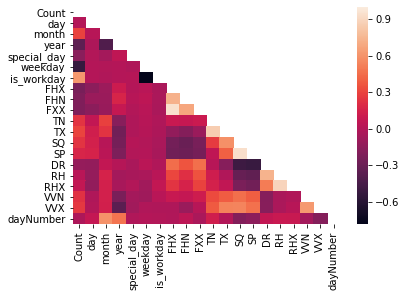

In [36]:
corr = raw_count_by_day.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask = mask)
plt.show()

## Baseline model
In previous analysis we observed a big difference in workday/not workday. That's why we'll use it as a baseline model. This served as the first submission in Kaggle.

In [37]:
# Set prediction column to average of workday/not workday
raw_count_by_day['pred'] = 0
raw_count_by_day['pred'].loc[raw_count_by_day.is_workday == 1] = np.round(raw_count_by_day.Count[raw_count_by_day.is_workday == 1].mean()).astype(int)
raw_count_by_day['pred'].loc[raw_count_by_day.is_workday == 0] = np.round(raw_count_by_day.Count[raw_count_by_day.is_workday == 0].mean()).astype(int)

C:\Users\berry\AppData\Local\Programs\Python\Python38-32\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [38]:
print('RMSE:', int(((raw_count_by_day['pred'][-93:-54] - raw_count_by_day['Count'][-93:-54]) ** 2).mean() ** .5))

RMSE: 108


In [39]:
# Create kaggle prediction
pred_rows = raw_count_by_day[-94:]
pred_rows.reset_index(inplace=True)
for index, row in pred_rows.iterrows():
    year = row['year']
    month = row['month'] if row['month'] > 9 else '0' + str(row['month'])
    day = row['day'] if row['day'] > 9 else '0' + str(row['day'])
    print(f"{year}{month}{day},{row['pred']}")

20191101,170
20191102,18
20191103,18
20191104,170
20191105,170
20191106,170
20191107,170
20191108,170
20191109,18
20191110,18
20191111,170
20191112,170
20191113,170
20191114,170
20191115,170
20191116,18
20191117,18
20191118,170
20191119,170
20191120,170
20191121,170
20191122,170
20191123,18
20191124,18
20191125,170
20191126,170
20191127,170
20191128,170
20191129,170
20191130,18
20191201,18
20191202,170
20191203,170
20191204,170
20191205,170
20191206,170
20191207,18
20191208,18
20191209,170
20191210,170
20191211,170
20191212,170
20191213,170
20191214,18
20191215,18
20191216,170
20191217,170
20191218,170
20191219,170
20191220,170
20191221,18
20191222,18
20191223,170
20191224,170
20191225,170
20191226,170
20191227,170
20191228,18
20191229,18
20191230,170
20191231,170
20200101,170
20200101,170
20200102,170
20200103,170
20200104,18
20200105,18
20200106,170
20200107,170
20200108,170
20200109,170
20200110,170
20200111,18
20200112,18
20200113,170
20200114,170
20200115,170
20200116,170
20200117

## Decision Tree Model
To predict better, we could use a decision tree using SKLearn.

In [40]:
split_date = pd.datetime(2019, 12, 9)
copy_model_df = model_df.loc[model_df.date_x < split_date]

data = copy_model_df.loc[:, copy_model_df.columns != 'date_x']
labels = data.pop('Count')


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels,
                                                    train_size=0.75, test_size=0.25, random_state=42)

In [42]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=0)
_ = model.fit(X_train, y_train)

In [43]:
from sklearn.metrics import mean_squared_error
print('RMSE:', mean_squared_error(y_test, model.predict(X_test), squared=False).round(2))

RMSE: 45.34


In [44]:
# Create kaggle prediction 2
pred_rows = model_df[-94:]
predictions = pd.DataFrame(columns=['date_x', 'Count'])
# pred_rows.reset_index(inplace=True)
for index, row in pred_rows.iterrows():
    year = row.date_x.year
    month = row.date_x.month if row.date_x.month > 9 else '0' + str(row.date_x.month)
    day = row.date_x.day if row.date_x.day > 9 else '0' + str(row.date_x.day)
    prediction = int(model.predict([row.drop(['date_x', 'Count'])])[0])
    predictions.loc[index] = [row.date_x, prediction]
    print(f"{year}{month}{day},{prediction}")

20191101,160
20191102,14
20191103,20
20191104,313
20191105,324
20191106,324
20191107,289
20191108,252
20191109,19
20191110,13
20191111,267
20191112,206
20191113,289
20191114,301
20191115,225
20191116,15
20191117,22
20191118,249
20191119,256
20191120,277
20191121,327
20191122,218
20191123,15
20191124,9
20191125,278
20191126,317
20191127,242
20191128,242
20191129,204
20191130,10
20191201,19
20191202,256
20191203,342
20191204,368
20191205,310
20191206,108
20191207,14
20191208,19
20191209,289
20191210,256
20191211,317
20191212,317
20191213,176
20191214,19
20191215,20
20191216,313
20191217,317
20191218,301
20191219,310
20191220,160
20191221,15
20191222,15
20191223,301
20191224,242
20191225,26
20191226,26
20191227,204
20191228,22
20191229,19
20191230,327
20191231,277
20200101,26
20200101,26
20200102,301
20200103,176
20200104,15
20200105,15
20200106,301
20200107,301
20200108,317
20200109,242
20200110,209
20200111,19
20200112,15
20200113,301
20200114,242
20200115,289
20200116,301
20200117,209


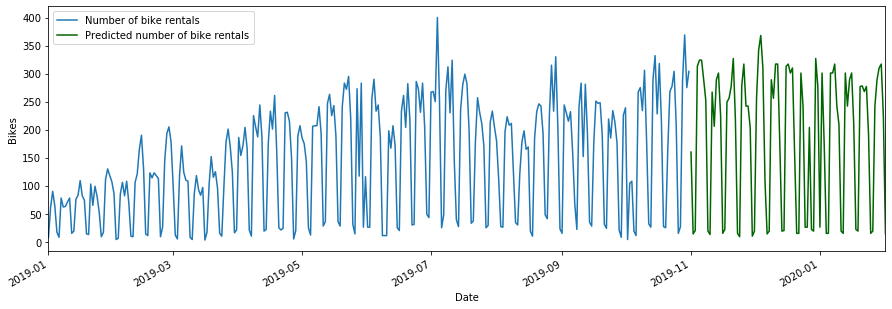

In [45]:
ax = model_df[:-94].plot(
    x='date_x', 
    y='Count', 
    label='Number of bike rentals',
    figsize=(15,5)
)

predictions.plot(
    x='date_x', 
    y='Count', 
    color="darkgreen", 
    label='Predicted number of bike rentals', 
    ax=ax
)
ax.set_xlabel("Date")
_ = ax.set_ylabel("Bikes")

### Conclusion of rental prediction
With an RMSE of ~45 the Decision Tree performed a lot better than the baseline model, in Kaggle the model performed even better, with an RMSE of ~37.

## Redistribution of bikes
To know where and when to distribute the bikes, we must know where the spikes are.

In [46]:
redistribute_df = original_df.copy()
redistribute_df.head()

,Unnamed: 0,tripid,userid,bikeid,account,bikenumber,start_time,end_time,start_lat,start_lng,end_lat,end_lng,date
0,1,33838,13452,382,AT,6631000433,2019-01-01 06:46:03,2019-01-01 06:46:03,52.296065,4.787667,52.296200,4.787679,2019-01-01 06:46:00
1,2,33839,13452,812,AT,6631000146,2019-01-01 06:47:39,2019-01-01 06:47:39,52.295938,4.788336,52.295940,4.788557,2019-01-01 06:47:35
2,3,33851,13182,238,AT,6631000443,2019-01-01 14:15:36,2019-01-01 14:15:36,52.307337,4.807633,52.307336,4.807630,2019-01-01 14:15:32
3,4,33852,13182,238,AT,6631000443,2019-01-01 14:33:50,2019-01-01 14:33:50,52.308478,4.809970,52.308537,4.810099,2019-01-01 14:33:46
4,5,33867,12674,787,AI,6631000283,2019-01-01 20:11:05,2019-01-01 20:11:05,52.510340,4.725336,52.508565,4.726276,2019-01-01 20:11:01


In [47]:
from ipyleaflet import Map, Heatmap

def create_map(hour):
    m = Map(center=(52.3, 4.82), zoom=12)

    heatmap = Heatmap(
        locations = [[x['start_lat'], x['start_lng']] for index, x in redistribute_df[original_df['start_time'].dt.hour == hour].iterrows()],
        radius = 12.5
    )

    m.add_layer(heatmap)
    return m

In [48]:
# Visualize map
from ipywidgets import interact
import ipywidgets as widgets

interact(create_map, hour=widgets.IntSlider(min=0, max=23, step=1, value=8, continuous_update=False));

interactive(children=(IntSlider(value=8, continuous_update=False, description='hour', max=23), Output()), _dom…

After we viewed some of the data, we will cluster the data based on their start and end location. After that, we will simulate a week of bike rental.

In [49]:
# Create bins width size 0.01 lat/lon.
step = 0.01
to_bin = lambda x: np.floor(x / step) * step
redistribute_df["out_latbin"] = redistribute_df.start_lat.map(to_bin)
redistribute_df["out_lonbin"] = redistribute_df.start_lng.map(to_bin)
redistribute_df["in_latbin"] = redistribute_df.end_lat.map(to_bin)
redistribute_df["in_lonbin"] = redistribute_df.end_lng.map(to_bin)
redistribute_df["hour"] = (redistribute_df.start_time.dt.hour // 2) * 2
redistribute_df["weekday"] = redistribute_df.start_time.dt.weekday
redistribute_df["week"] = redistribute_df.start_time.dt.week
num_weeks = redistribute_df.week.max()

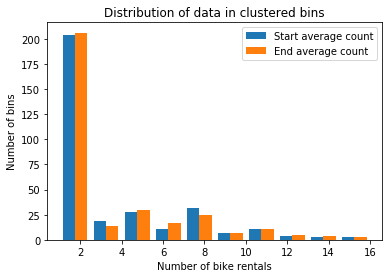

In [50]:
# Group data by made bins
import math
out_grouped = redistribute_df.groupby(['out_latbin', 'out_lonbin', 'weekday', 'hour']).size().reset_index()
out_grouped.columns = ['lat', 'lon', 'weekday', 'hour', 'count']
out_grouped = out_grouped.sort_values('count', ascending=False)
out_grouped['average'] = out_grouped['count'].apply(lambda count: math.ceil(count / num_weeks) if count > 13 else math.floor(count / num_weeks))

in_grouped = redistribute_df.groupby(['in_latbin', 'in_lonbin', 'weekday', 'hour']).size().reset_index()
in_grouped.columns = ['lat', 'lon', 'weekday', 'hour', 'count']
in_grouped = in_grouped.sort_values('count', ascending=False)
in_grouped['average'] = in_grouped['count'].apply(lambda count: math.ceil(count / num_weeks) if count > 13 else math.floor(count / num_weeks))

plt.hist([out_grouped['average'][out_grouped.average > 0], in_grouped['average'][in_grouped.average > 0]], label=['Start average count', 'End average count'])
plt.legend(loc='upper right')
plt.title("Distribution of data in clustered bins")
plt.xlabel("Number of bike rentals")
plt.ylabel("Number of bins")

plt.show()

In [51]:
out_unique_combinations = out_grouped.groupby(['lat', 'lon']).size().reset_index().rename(columns={0:'count'})
del out_unique_combinations['count']
in_unique_combinations = in_grouped.groupby(['lat', 'lon']).size().reset_index().rename(columns={0:'count'})
del in_unique_combinations['count']

all_combinations = pd.merge(in_unique_combinations, out_unique_combinations, on=['lat','lon'], how='outer')
all_combinations.head()

,lat,lon
0,51.51,-0.13
1,51.86,4.27
2,51.87,4.24
3,51.87,4.26
4,51.87,4.32


This table shows the top 5 peaks in the week in blocks of 2 hours (So hour = 8 means between 8 and 10).

Now we will create a simulation for the possible bike shortages. Those will be identified and the closest points will be used to get bikes from, taking the average bike rentals into account.

In [52]:
# Create dictionary entry for each unique location
bikes = {str(lat):{} for lat in all_combinations['lat'].unique().round(2)}

for index, combination in all_combinations.iterrows():
    bikes[str(combination.lat.round(2))][str(combination.lon.round(2))] = 5

points = list(zip(all_combinations['lat'].round(2), all_combinations['lon'].round(2)))

In [53]:
import copy

def get_bikes(dataframe, weekday, hour, lat, lon):
    """ Returns the number of bikes rented which matches given parameters. """
    average_bikes = dataframe[
        (dataframe['weekday'] == weekday) &
        (dataframe['hour'] == hour) &
        (dataframe['lat'] >= lat) & ((dataframe['lat']) < lat + step) &
        (dataframe['lon'] >= lon) & ((dataframe['lon']) < lon + step)
    ]['average']
    return average_bikes.values[0] if len(average_bikes) > 0 else 0 

def find_closest_surplus(search_list, lat, lon, day, hour, requested_bikes):
    """" Returns the location and the number of possible bikes to get from the position given a list of locations and time. """
    lat = float(lat)
    lon = float(lon)

    if (lat,lon) in search_list:
        copy_search_list = copy.deepcopy(search_list)
        copy_search_list.remove((lat,lon))
    else:
        copy_search_list = search_list
    

    point_to_check = closest_point((lat, lon), copy_search_list)
    
    number_of_bikes = bikes[str(point_to_check[0])][str(point_to_check[1])]
    avg_needed_bikes = get_bikes(out_grouped, day, hour, point_to_check[0], point_to_check[1])
    
    available_bikes = 0
    if number_of_bikes > avg_needed_bikes:
        available_bikes = number_of_bikes - avg_needed_bikes
    
    if available_bikes >= requested_bikes:   
        return point_to_check, available_bikes
    else:
        if point_to_check in copy_search_list:
            copy_search_list.remove(point_to_check)
        return find_closest_surplus(copy_search_list, lat, lon, day, hour, requested_bikes)

def move_bikes(from_location, to_location, number_of_bikes):
    """" Moves bikes from a location to another given location. """
    bikes[str(from_location[0])][str(from_location[1])] -= number_of_bikes
    bikes[str(to_location[0])][str(to_location[1])] += number_of_bikes

def simulate_location(day, hour, lat, lon):
    """ Checks outgoing and ingoing bikes. If any shortages are there, it will try to fix the shortage. """
    outgoing_bikes = get_bikes(out_grouped, day, hour, float(lat), float(lon))
    bikes[lat][lon] -= outgoing_bikes

    while bikes[lat][lon] < 0:
        # Shortage found, find place to get bikes
        print(f"Shortage at Location: ({lat},{lon}): {bikes[lat][lon]}. On {daysMap[day]} between {hour}:00 and {hour+2}:00.")
        
        shortage = abs(bikes[lat][lon]) + 1
        location, available_bikes = find_closest_surplus(points, lat, lon, day, hour, shortage)
        move_bikes(location, (lat,lon), shortage if available_bikes >= shortage else available_bikes)
        print(f"Fixed shortage by moving {shortage} bikes from {location} to {(float(lat),float(lon))}.\n")
        
    incoming_bikes = get_bikes(in_grouped, day, hour, float(lat), float(lon))
    bikes[lat][lon] += incoming_bikes

def simulate_hour(day, hour):
    """ Simulate an hour of simulation """
    for lat, lons in bikes.items():
            for lon in bikes[lat]:
                simulate_location(day, hour, lat, lon)
    
def simulate_day(day):
    """ Simulate a day of simulation """
    for hour in range(0, 24, 2):
        simulate_hour(day, hour)

In [54]:
count = 0
total = 7
for day in range(0, 7):
    simulate_day(day)
    count += 1

Shortage at Location: (52.3,4.8): -2. On Monday between 6:00 and 8:00.
Fixed shortage by moving 3 bikes from (52.29, 4.8) to (52.3, 4.8).

Shortage at Location: (52.29,4.79): -2. On Monday between 8:00 and 10:00.
Fixed shortage by moving 3 bikes from (52.28, 4.79) to (52.29, 4.79).

Shortage at Location: (52.3,4.79): -1. On Monday between 8:00 and 10:00.
Fixed shortage by moving 2 bikes from (52.3, 4.78) to (52.3, 4.79).

Shortage at Location: (52.3,4.8): -4. On Monday between 8:00 and 10:00.
Fixed shortage by moving 5 bikes from (52.3, 4.81) to (52.3, 4.8).

Shortage at Location: (52.3,4.79): -1. On Monday between 12:00 and 14:00.
Fixed shortage by moving 2 bikes from (52.29, 4.79) to (52.3, 4.79).

Shortage at Location: (52.3,4.81): -2. On Monday between 12:00 and 14:00.
Fixed shortage by moving 3 bikes from (52.29, 4.81) to (52.3, 4.81).

Shortage at Location: (52.3,4.8): -1. On Monday between 14:00 and 16:00.
Fixed shortage by moving 2 bikes from (52.29, 4.8) to (52.3, 4.8).

Short

### Conclusion
Above simulation is a relative oversimplified simulation, and probably not perfect, but it is a good start and using more predictive models it could also be possible to check more than only the average of that hour on that day, for example, on the summer period there are a lot less bikes needed, which currently is not taken into account.

## With how many bikes could Flickbike function?
To answer this question, we should find out what the highest peek is that is available in the data.

Also, this question is a question that could be taken really broad. Cause, this could also mean that maybe FlickBike doesn't even want to catch the peeks, since that would cost them more money than they would get from it. But since we do not have access to that data, we will assume they want to get all clients they can possibly get.

In [55]:
original_df['hour'] = original_df.date.dt.hour
original_df['day'] = original_df.date.dt.day
original_df['month'] = original_df.date.dt.month
original_df['year'] = original_df.date.dt.year

In [56]:
grouped_by_hour = original_df.groupby(['hour','day','month','year']).size().reset_index().rename({0:'Count'}, axis=1).sort_values('Count', ascending=False)
grouped_by_hour.head()

,hour,day,month,year,Count
2136,12,5,11,2019,85
989,8,5,11,2019,56
3381,16,5,11,2019,53
1249,9,4,7,2019,52
1117,8,19,11,2019,50


With the current data, we can not say much more than that:
- The current highest peak is 85 in an hour. That means Flickbike could theoretically function which such numbers of bikes, if they have enough people to move around the bikes. This is also something we do not have access to.
- We've seen some growth in earlier charts. One problem with that is the following: We only have one year of data. To really say something about growth (taking periodicity into account) is not really possible with one year of data. So we can not really estimate the growth percentage of the peaks either.